# Netflix TV Shows & Movies - Deep Dive

## Set Up Environment

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in CSV file into a pandas dataframes.
netflix = pd.read_csv('data/netflix_titles_clean.csv')

In [3]:
# Run data cleaning steps to ensure data is in the right format.

netflix['date_added'] = pd.to_datetime(netflix.date_added)
netflix['year_added'] = pd.to_datetime(netflix.year_added)

def convert_to_list(text):
    text = text.replace("[", '').replace("]", '').replace("'", '')
    if ',' not in text:
        return [text]
    else:
        converted_text = text.split(',')
        for x in converted_text:
            converted_text[converted_text.index(x)] = x.strip()
        return converted_text

list_columns = ['director_list', 'cast_list', 'country_list', 'listed_in_list']
for col in list_columns:
    netflix[col] = netflix[col].apply(convert_to_list)

tv_shows = netflix[netflix.type == 'TV Show'].copy()
movies = netflix[netflix.type == 'Movie'].copy()
movies['duration'] = movies.duration.str.replace(' min', '').astype('int')

netflix.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
0,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,1970-01-01 00:00:00.000002020,[Unknown],"[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil],"[International TV Shows, TV Dramas, TV Sci-Fi ...",1,11,1,3
1,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,1970-01-01 00:00:00.000002016,[Jorge Michel Grau],"[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico],"[Dramas, International Movies]",1,6,1,2
2,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",1970-01-01 00:00:00.000002018,[Gilbert Chan],"[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore],"[Horror Movies, International Movies]",1,9,1,2


## Analysis

### Deep Dive
6. Length of cast by country.
7. Proportion of shows vs movies by country.
8. Range of directors in terms of number of countries.
9. Average movie length by genre and country.
10. TV show tenure by genre.
11. Deeper dive into specific regions (e.g. Africa).

### Natural Language Processing
12. Most common words in descriptions overall and by genre.

### 6. Length of cast by country.

In [4]:
netflix[['country','cast_size']]

,country,cast_size
0,Brazil,11
1,Mexico,6
2,Singapore,9
3,United States,9
4,United States,12
...,...,...
7782,"Sweden, Czech Republic, United Kingdom, Denmar...",7
7783,India,8
7784,Unknown,1
7785,Australia,2


In [5]:
# Create a unique list of countries.
countries_list = []
for entry in list(netflix.country_list):
    for x in entry:
        if x not in countries_list:
            countries_list.append(x)

In [6]:
# Calculate the average cast size for each country.
cast_sizes_by_country = {}
for c in countries_list:
    indexes = []
    for i in list(netflix.index):
        countries = netflix.loc[i, 'country_list']
        if c in countries:
            indexes.append(i)
    subset_df = netflix.loc[indexes, :]
    avg_cast_size = round(subset_df.cast_size.mean(), 2)
    cast_sizes_by_country[c] = avg_cast_size

# Convert cast_sizes_by_country to a dataframe.
country_data = pd.DataFrame(pd.Series(cast_sizes_by_country), columns=['avg_cast_size'])

# Countries with the highest and lowest average cast size.
country_data.sort_values(by='avg_cast_size', ascending=False)

,avg_cast_size
Paraguay,13.0
Lithuania,13.0
Syria,12.0
Azerbaijan,11.0
Latvia,11.0
...,...
Sri Lanka,1.0
Panama,1.0
Uganda,1.0
Nicaragua,1.0


### 7. Proportion of shows vs movies by country.

In [7]:
country_data.head()

,avg_cast_size
Brazil,7.14
Mexico,8.56
Singapore,6.87
United States,7.29
Turkey,8.78


In [8]:
# Calculate the number of tv shows and movies there are from each country.
tv_shows_by_country = {}
movies_by_country = {}
for c in countries_list:
    indexes = []
    for i in list(netflix.index):
        countries = netflix.loc[i, 'country_list']
        if c in countries:
            indexes.append(i)
    subset_df = netflix.loc[indexes, :]
    tv_show_count = len(subset_df[subset_df.type == 'TV Show'])
    movie_count = len(subset_df[subset_df.type == 'Movie'])
    tv_shows_by_country[c] = tv_show_count
    movies_by_country[c] = movie_count

In [9]:
# Add tv and movie counts to 'country_data' dataframe.
country_data['tv_count'] = country_data.index.map(tv_shows_by_country)
country_data['movie_count'] = country_data.index.map(movies_by_country)

# Calculate percent of entries that are tv shows and movies for each country.
country_data['tv_percent'] = country_data.tv_count / (country_data.tv_count + country_data.movie_count) * 100
country_data['movie_percent'] = country_data.movie_count / (country_data.tv_count + country_data.movie_count) * 100

country_data

,avg_cast_size,tv_count,movie_count,tv_percent,movie_percent
Brazil,7.14,29,59,32.954545,67.045455
Mexico,8.56,53,101,34.415584,65.584416
Singapore,6.87,21,18,53.846154,46.153846
United States,7.29,866,2431,26.266303,73.733697
Turkey,8.78,28,80,25.925926,74.074074
...,...,...,...,...,...
Sudan,10.00,0,1,0.000000,100.000000
Panama,1.00,0,1,0.000000,100.000000
Uganda,1.00,0,1,0.000000,100.000000
East Germany,10.00,0,1,0.000000,100.000000


### 8. Range of directors in terms of number of countries.

In [10]:
# Create a unique list of directors.
directors_list = []
for entry in list(netflix.director_list):
    for x in entry:
        if x not in directors_list:
            directors_list.append(x)

In [11]:
# Calculate the number of netflix tv shows and movies each director has directed.
country_count_by_director = {}
for d in directors_list:
    indexes = []
    for i in list(netflix.index):
        directors = netflix.loc[i, 'director_list']
        if d in directors:
            indexes.append(i)
    subset_df = netflix.loc[indexes, :]
    country_count = {}
    for entry in subset_df.country.unique():
        for x in entry:
            if x not in country_count:
                country_count[x] = 1
            else:
                country_count[x] += 1
    
    country_count_by_director[d] = len(country_count)

In [12]:
# Directors with the highest number of tv shows and movies on Netflix.
pd.Series(country_count_by_director).sort_values(ascending=False)[1:11]

Martin Campbell       31
Matthew Salleh        30
Josef Fares           29
James Watkins         28
Andrzej Bartkowiak    27
Philippe Aractingi    27
Brian De Palma        27
Ari Folman            27
Joshua Oppenheimer    27
Michael J. Bassett    26
dtype: int64

### 9. Average movie length by genre and country.

In [13]:
movies.head(2)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
1,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,1970-01-01 00:00:00.000002016,[Jorge Michel Grau],"[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico],"[Dramas, International Movies]",1,6,1,2
2,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",1970-01-01 00:00:00.000002018,[Gilbert Chan],"[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore],"[Horror Movies, International Movies]",1,9,1,2


In [14]:
# Shortest Netflix movies.
movies[movies.duration < 10]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
1203,Movie,Canvas,Frank E. Abney III,Unknown,United States,2020-12-11,2020,G,9,"Children & Family Movies, Dramas","After a heartbreaking loss, a grandfather stru...",1970-01-01 00:00:00.000002020,[Frank E. Abney III],[Unknown],[United States],"[Children & Family Movies, Dramas]",1,1,1,2
1501,Movie,Cops and Robbers,"Arnon Manor, Timothy Ware-Hill",Timothy Ware-Hill,United States,2020-12-28,2020,PG-13,8,Dramas,Animation and activism unite in this multimedi...,1970-01-01 00:00:00.000002020,"[Arnon Manor, Timothy Ware-Hill]",[Timothy Ware-Hill],[United States],[Dramas],2,1,1,1
5605,Movie,Silent,"Limbert Fabian, Brandon Oldenburg",Unknown,United States,2019-06-04,2014,TV-Y,3,"Children & Family Movies, Sci-Fi & Fantasy","""Silent"" is an animated short film created by ...",1970-01-01 00:00:00.000002019,"[Limbert Fabian, Brandon Oldenburg]",[Unknown],[United States],"[Children & Family Movies, Sci-Fi & Fantasy]",2,1,1,2
5694,Movie,Sol Levante,Akira Saitoh,Unknown,Japan,2020-04-02,2020,TV-14,5,"Action & Adventure, Anime Features, Internatio...",A young warrior and her familiar search for th...,1970-01-01 00:00:00.000002020,[Akira Saitoh],[Unknown],[Japan],"[Action & Adventure, Anime Features, Internati...",1,1,1,3


In [15]:
# Longest Netflix movies.
movies[movies.duration > 240]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
957,Movie,Black Mirror: Bandersnatch,Unknown,"Fionn Whitehead, Will Poulter, Craig Parkinson...",United States,2018-12-28,2018,TV-MA,312,"Dramas, International Movies, Sci-Fi & Fantasy","In 1984, a young programmer begins to question...",1970-01-01 00:00:00.000002018,[Unknown],"[Fionn Whitehead, Will Poulter, Craig Parkinso...",[United States],"[Dramas, International Movies, Sci-Fi & Fantasy]",1,5,1,3
6850,Movie,The School of Mischief,Houssam El-Din Mustafa,"Suhair El-Babili, Adel Emam, Saeed Saleh, Youn...",Egypt,2020-05-21,1973,TV-14,253,"Comedies, Dramas, International Movies",A high school teacher volunteers to transform ...,1970-01-01 00:00:00.000002020,[Houssam El-Din Mustafa],"[Suhair El-Babili, Adel Emam, Saeed Saleh, You...",[Egypt],"[Comedies, Dramas, International Movies]",1,7,1,3


In [16]:
# Create a unique list of genres.
genres_list = []
for entry in list(netflix.listed_in_list):
    for x in entry:
        if x not in genres_list:
            genres_list.append(x)

In [17]:
# Calculate the number of movies and their average duration for each genre.
count_by_genre_movie = {}
avg_duration_by_genre = {}
for g in genres_list:
    indexes = []
    for i in list(movies.index):
        genres = movies.loc[i, 'listed_in_list']
        if g in genres:
            indexes.append(i)
    subset_df = movies.loc[indexes, :]
    count = len(subset_df)
    avg_duration = subset_df.duration.mean()
    count_by_genre_movie[g] = count
    avg_duration_by_genre[g] = avg_duration

genre_duration = pd.DataFrame(pd.Series(avg_duration_by_genre), columns=['avg_duration'])
genre_duration['movie_count'] = genre_duration.index.map(count_by_genre_movie)
genre_duration.dropna(inplace=True)
genre_duration.sort_values(by='avg_duration', inplace=True)
genre_duration

,avg_duration,movie_count
Movies,45.946429,56
Stand-Up Comedy,67.060790,329
Children & Family Movies,79.716165,532
Documentaries,81.376590,786
Anime Features,91.210526,57
LGBTQ Movies,93.966667,90
Sports Movies,95.367347,196
Horror Movies,97.544872,312
Independent Movies,100.754829,673
Comedies,104.551326,1471


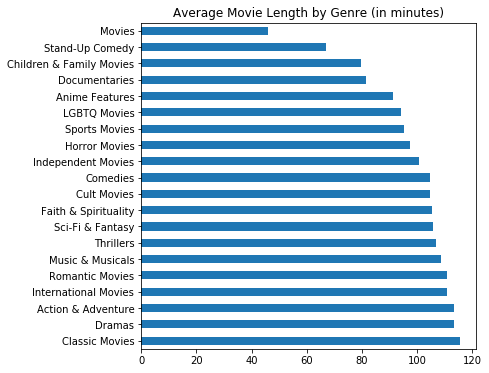

In [18]:
genre_duration.avg_duration.sort_values(ascending=False).plot.barh(figsize=(6,6), title='Average Movie Length by Genre (in minutes)')

In [19]:
# Calculate the number of movies and their average duration for each country.
avg_duration_by_country = {}
for c in countries_list:
    indexes = []
    for i in list(movies.index):
        countries = movies.loc[i, 'country_list']
        if c in countries:
            indexes.append(i)
    subset_df = movies.loc[indexes, :]
    avg_duration = subset_df.duration.mean()
    avg_duration_by_country[c] = avg_duration

country_duration = pd.DataFrame(pd.Series(avg_duration_by_country), columns=['avg_duration'])
country_duration['movie_count'] = country_duration.index.map(movies_by_country)
country_duration.dropna(inplace=True)
country_duration.sort_values(by='avg_duration', inplace=True)
country_duration

,avg_duration,movie_count
Kazakhstan,67.000000,1
Uganda,68.000000,1
Guatemala,68.000000,2
Namibia,69.500000,2
Georgia,71.500000,2
...,...,...
Morocco,137.333333,6
Bahamas,145.000000,1
Soviet Union,156.666667,3
Montenegro,157.000000,1


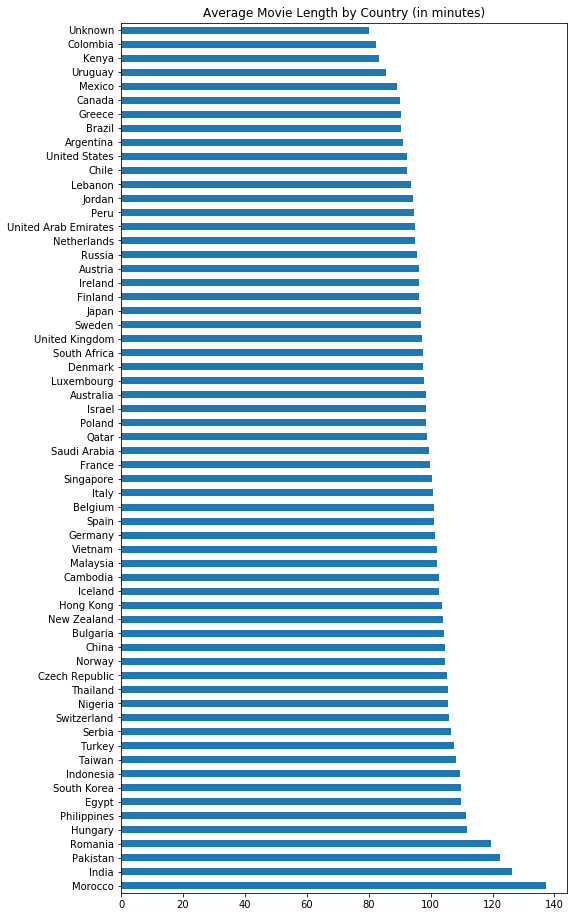

In [20]:
country_duration[country_duration.movie_count >= 5].avg_duration.sort_values(ascending=False).plot.barh(
    figsize=(8,16), title='Average Movie Length by Country (in minutes)')

### 10. TV show tenure by genre.

In [21]:
tv_shows.head(2)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
0,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,1970-01-01 00:00:00.000002020,[Unknown],"[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil],"[International TV Shows, TV Dramas, TV Sci-Fi ...",1,11,1,3
5,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,2017-07-01,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,1970-01-01 00:00:00.000002017,[Serdar Akar],"[Erdal Beşikçioğlu, Yasemin Allen, Melis Birka...",[Turkey],"[International TV Shows, TV Dramas, TV Mysteries]",1,10,1,3


In [22]:
# Frequency distribution of tv shows by number of seasons.
tv_shows.duration.value_counts()

1 Season      1608
2 Seasons      382
3 Seasons      184
4 Seasons       87
5 Seasons       58
6 Seasons       30
7 Seasons       19
8 Seasons       18
9 Seasons        8
10 Seasons       6
11 Seasons       3
13 Seasons       2
12 Seasons       2
15 Seasons       2
16 Seasons       1
Name: duration, dtype: int64

In [23]:
# Longest tenured tv show on Netflix.
tv_shows[tv_shows.duration == '16 Seasons']

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
2538,TV Show,Grey's Anatomy,Unknown,"Ellen Pompeo, Sandra Oh, Katherine Heigl, Just...",United States,2020-05-09,2019,TV-14,16 Seasons,"Romantic TV Shows, TV Dramas",Intern (and eventual resident) Meredith Grey f...,1970-01-01 00:00:00.000002020,[Unknown],"[Ellen Pompeo, Sandra Oh, Katherine Heigl, Jus...",[United States],"[Romantic TV Shows, TV Dramas]",1,15,1,2


In [24]:
# Create a dataframe with the number of tv shows for each genre and length by seasons.
count_by_genre_tv = {}
length_dist_by_genre = {}
for g in genres_list:
    indexes = []
    for i in list(tv_shows.index):
        genres = tv_shows.loc[i, 'listed_in_list']
        if g in genres:
            indexes.append(i)
    subset_df = tv_shows.loc[indexes, :]
    count = len(subset_df)
    length_dist = dict(subset_df.duration.value_counts())
    count_by_genre_tv[g] = count
    length_dist_by_genre[g] = length_dist

tv_genre_season = pd.DataFrame.from_dict(length_dist_by_genre, orient='index')
tv_genre_season_cols = [
    '1 Season',
    '2 Seasons',
    '3 Seasons',
    '4 Seasons',
    '5 Seasons',
    '6 Seasons',
    '7 Seasons',
    '8 Seasons',
    '9 Seasons',
    '10 Seasons',
    '11 Seasons',
    '12 Seasons',
    '13 Seasons',
    '15 Seasons',
    '16 Seasons',
]
tv_genre_season = tv_genre_season.reindex(columns=tv_genre_season_cols)
tv_genre_season['total'] = tv_genre_season.index.map(count_by_genre_tv)
tv_genre_season.fillna(0, inplace=True)
tv_genre_season = tv_genre_season.astype('int')
tv_genre_season.sort_values(by='total', ascending=False, inplace=True)
tv_genre_season

,1 Season,2 Seasons,3 Seasons,4 Seasons,5 Seasons,6 Seasons,7 Seasons,8 Seasons,9 Seasons,10 Seasons,11 Seasons,12 Seasons,13 Seasons,15 Seasons,16 Seasons,total
International TV Shows,940,151,60,23,13,2,4,2,3,0,0,1,0,0,0,1199
TV Dramas,489,81,53,24,20,12,11,6,3,1,1,1,0,1,1,704
TV Comedies,291,99,48,29,19,13,7,9,2,4,2,0,2,0,0,525
Crime TV Shows,295,62,33,9,12,5,3,4,1,0,0,2,0,1,0,427
"""Kids TV""",205,118,44,27,10,4,0,4,0,2,0,0,0,0,0,414
Docuseries,292,28,20,5,4,2,0,1,1,0,0,0,0,0,0,353
Romantic TV Shows,280,23,13,7,1,3,3,1,1,0,0,0,0,0,1,333
British TV Shows,143,45,19,11,8,1,0,1,2,2,0,0,0,0,0,232
Reality TV,149,44,17,7,1,3,0,1,0,0,0,0,0,0,0,222
Korean TV Shows,124,20,4,1,1,0,0,0,0,0,0,0,0,0,0,150


In [25]:
# Aggregate columns for 4 or more seasons into 1 summary column.
four_plus_seasons = [
    '4 Seasons',
    '5 Seasons',
    '6 Seasons',
    '7 Seasons',
    '8 Seasons',
    '9 Seasons',
    '10 Seasons',
    '11 Seasons',
    '12 Seasons',
    '13 Seasons',
    '15 Seasons',
    '16 Seasons',
]
over_four_season_sum = tv_genre_season[four_plus_seasons].sum(axis=1)
tv_genre_season_pct = tv_genre_season[['1 Season','2 Seasons','3 Seasons']].copy()
tv_genre_season_pct['4+ Seasons'] = over_four_season_sum
tv_genre_season_pct['total'] = tv_genre_season.total
tv_genre_season_pct

,1 Season,2 Seasons,3 Seasons,4+ Seasons,total
International TV Shows,940,151,60,48,1199
TV Dramas,489,81,53,81,704
TV Comedies,291,99,48,87,525
Crime TV Shows,295,62,33,37,427
"""Kids TV""",205,118,44,47,414
Docuseries,292,28,20,13,353
Romantic TV Shows,280,23,13,17,333
British TV Shows,143,45,19,25,232
Reality TV,149,44,17,12,222
Korean TV Shows,124,20,4,2,150


In [26]:
# Calculate percentages by # of seasons for each genre and add to dataframe.
tgsp_norm_cols = tv_genre_season_pct.columns.tolist()
tgsp_norm_cols.remove('total')
tgsp_norm_cols
for col in tgsp_norm_cols:
    tv_genre_season_pct['{}_pct'.format(col)] = tv_genre_season_pct[col] / tv_genre_season_pct.total * 100

tv_genre_season_pct = tv_genre_season_pct.reindex(columns=[
    '1 Season',
    '1 Season_pct',
    '2 Seasons',
    '2 Seasons_pct',
    '3 Seasons',
    '3 Seasons_pct',
    '4+ Seasons',
    '4+ Seasons_pct',
    'total'
])
tv_genre_season_pct

,1 Season,1 Season_pct,2 Seasons,2 Seasons_pct,3 Seasons,3 Seasons_pct,4+ Seasons,4+ Seasons_pct,total
International TV Shows,940,78.398666,151,12.593828,60,5.004170,48,4.003336,1199
TV Dramas,489,69.460227,81,11.505682,53,7.528409,81,11.505682,704
TV Comedies,291,55.428571,99,18.857143,48,9.142857,87,16.571429,525
Crime TV Shows,295,69.086651,62,14.519906,33,7.728337,37,8.665105,427
"""Kids TV""",205,49.516908,118,28.502415,44,10.628019,47,11.352657,414
Docuseries,292,82.719547,28,7.932011,20,5.665722,13,3.682720,353
Romantic TV Shows,280,84.084084,23,6.906907,13,3.903904,17,5.105105,333
British TV Shows,143,61.637931,45,19.396552,19,8.189655,25,10.775862,232
Reality TV,149,67.117117,44,19.819820,17,7.657658,12,5.405405,222
Korean TV Shows,124,82.666667,20,13.333333,4,2.666667,2,1.333333,150


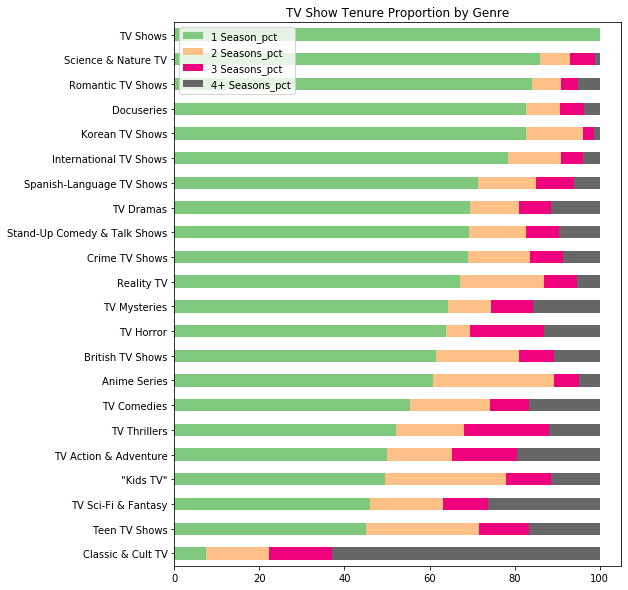

In [27]:
# Graph percentages for each genre using a stacked bar chart.
stacked_bar_cols = ['1 Season_pct','2 Seasons_pct','3 Seasons_pct','4+ Seasons_pct']
tv_genre_season_pct[stacked_bar_cols].sort_values(by='1 Season_pct').plot.barh(
    stacked=True, figsize=(8,10), cmap='Accent', title='TV Show Tenure Proportion by Genre')

### 11. Deeper dive into specific regions (e.g. Africa).

See Netflix_Region_Comparison notebook.

## Analysis: Natural Language Processing

### 12. Most common words in descriptions overall and by genre.

In [28]:
# Import libraries needed for text analysis.
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/antiri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
us_descriptions = netflix[netflix.country == 'United States']
us_descriptions.description

3       In a postapocalyptic world, rag-doll robots hi...
4       A brilliant group of students become card-coun...
7       After one of his high school students attacks ...
10      A farmer pens a confession admitting to his wi...
14      Stranded when the Earth is suddenly destroyed ...
                              ...                        
7758    Zack and Miri make and star in an adult film t...
7771    Born without legs and stuck in foster care for...
7774    A political cartoonist, a crime reporter and a...
7778    Looking to survive in a world taken over by zo...
7781    Dragged from civilian life, a former superhero...
Name: description, Length: 2555, dtype: object

In [31]:
# This function uses a vectorizer to determine the most common words and presents that information in a dataframe.
def create_word_distribution(text_series, method, stop_words=None):
    vectorizer = method(stop_words=stop_words)
    text_terms = vectorizer.fit_transform(text_series)
    text_df = pd.DataFrame(text_terms.toarray().T, index=vectorizer.get_feature_names())
    
    if method == CountVectorizer:
        text_df['total'] = text_df.sum(axis=1)
        text_df['document_count'] = (text_df>0).sum(axis=1)
        text_df['overall_document_pct'] = round((text_df>0).sum(axis=1) / len(text_series) * 100, 2)
        text_df.sort_values(by='total', ascending=False, inplace=True)
    elif method == TfidfVectorizer:
        old_cols = list(text_df.columns)
        new_cols = list(text_series.index)
        columns_map = dict(zip(old_cols, new_cols))
        text_df.rename(columns=columns_map, inplace=True)
    
    return text_df

In [32]:
my_stop_words = ['the', 'and', 'to', 'of', 'in', 'an', 'for', 'when', 'as', 'is', 'on', 'by', 'up', 'that', 'who', 'at',
                'into', 'but', 'it', 'from', 'his', 'her', 'this', 'their', 'he', 'she', 'they', 'him', 'with', 'after',
                'about', 'are', 'be', 'them', 'has', 'its', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
                'nine', 'ten', '15', '500']

In [33]:
# Most common words appearing in descriptions of US-based shows and movies on Netflix.
create_word_distribution(us_descriptions.description, CountVectorizer, my_stop_words)[['total']].head(10)

,total
life,267
new,256
world,164
documentary,155
family,154
series,144
young,136
out,134
school,122
high,116


In [34]:
# This function returns the most common words appearing in descriptions for a specific genre.
def identify_top_words_by_genre(df, genre, n_words, stop_words=None):
    indexes = []
    for i in list(df.index):
        genres = df.loc[i, 'listed_in_list']
        if genre in genres:
            indexes.append(i)
    subset_df = df.loc[indexes, :]
    top_words_df = create_word_distribution(subset_df.description, CountVectorizer, stop_words).head(n_words)
    top_words_df['subset_document_pct'] = round(top_words_df.document_count / len(subset_df) * 100, 2)
    top_words_df = top_words_df[['total', 'overall_document_pct', 'subset_document_pct']]
    return top_words_df

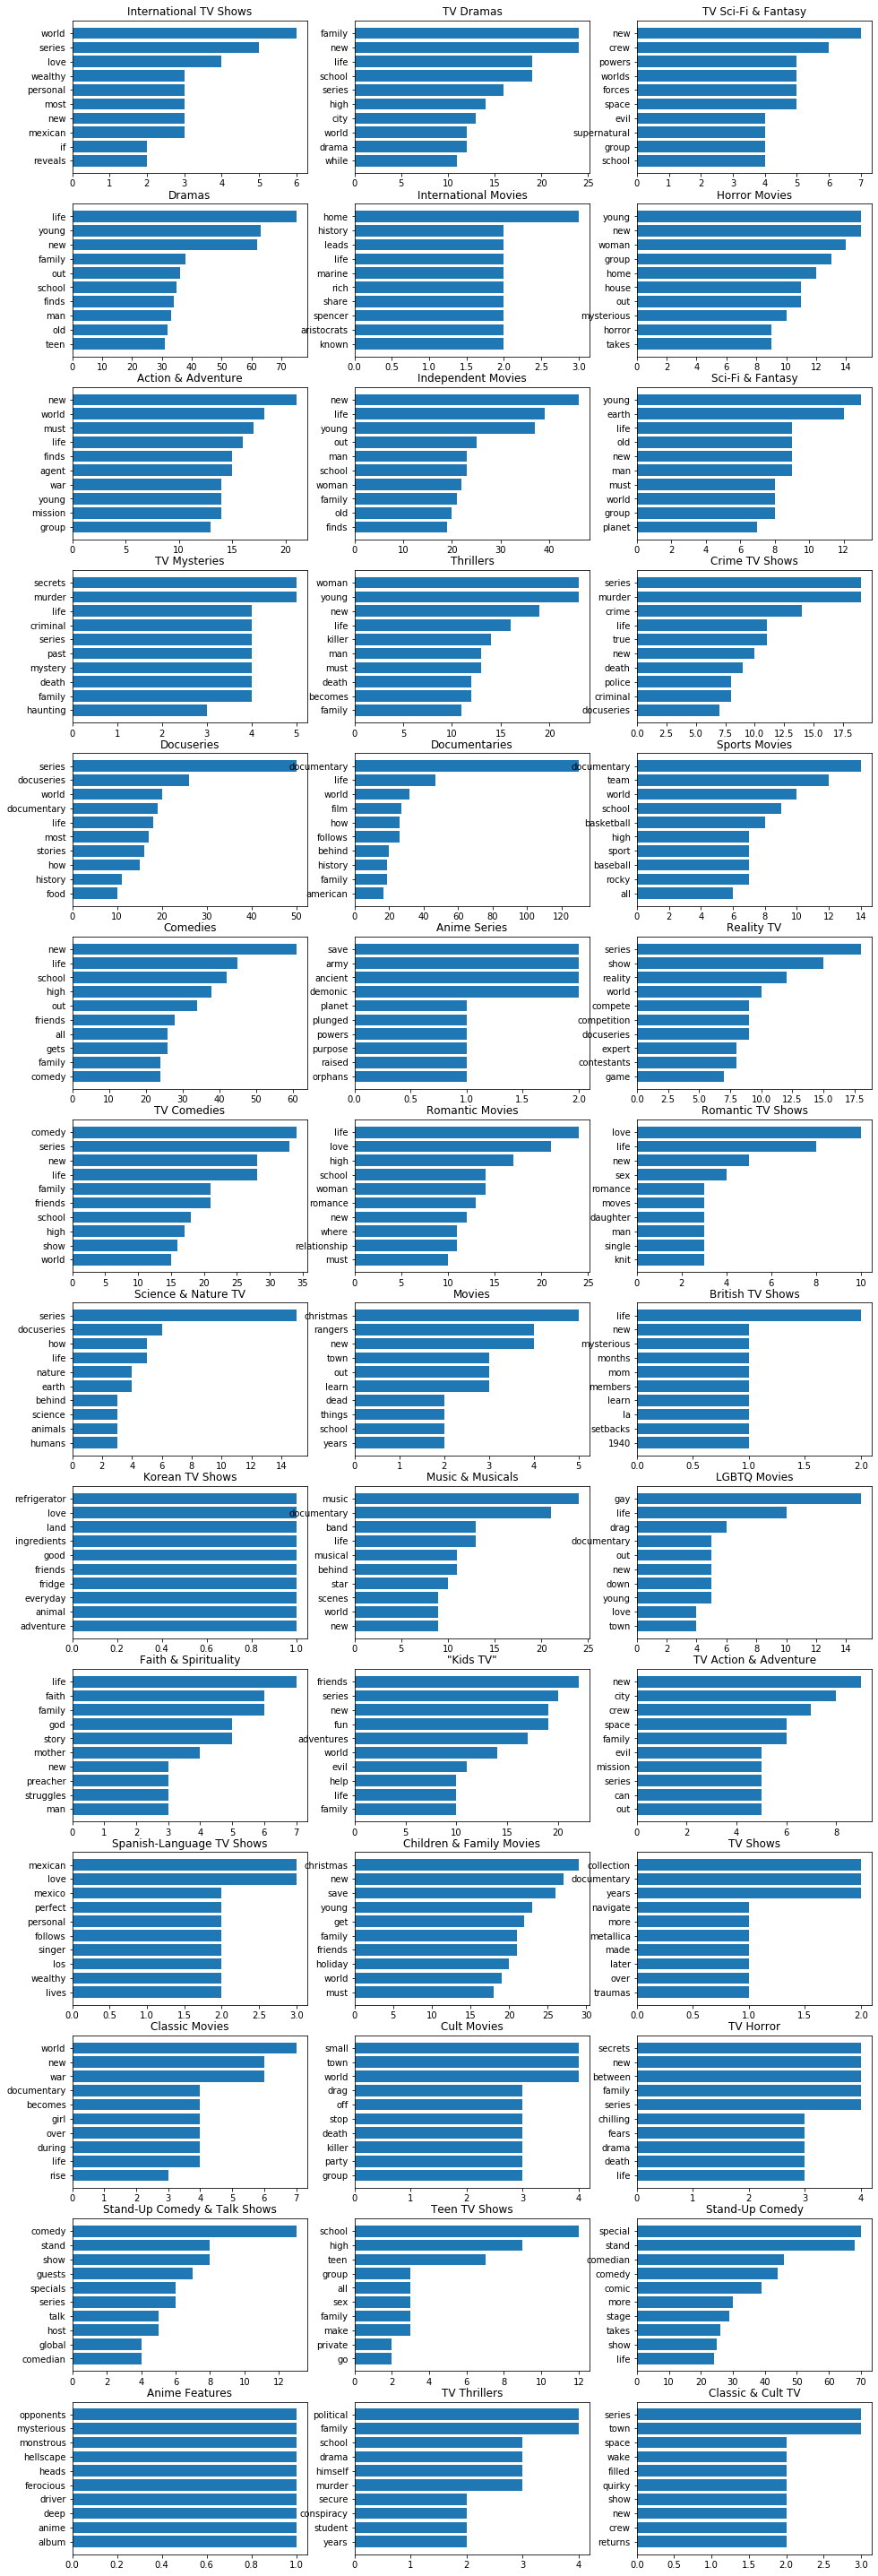

In [35]:
# Top 10 words for each genre.
fig = plt.figure(figsize=(16,52))

for i in range(1, len(genres_list) + 1):
    top_words = identify_top_words_by_genre(us_descriptions, genres_list[i-1], 10, my_stop_words)
    top_words.sort_values(by='total', inplace=True)
    x = top_words.index
    y = top_words.total
    
    ax = fig.add_subplot(len(genres_list)/3, 3, i)
    ax.barh(x, y)
    ax.set_title(genres_list[i-1])